In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import cv2
import glob
import time
import pickle
import collections

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from  sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

%matplotlib inline

from collections import deque
history = deque(maxlen = 8)

In [ ]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [ ]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2,
                     hist_range=(0, 256), hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features) 

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    # Return list of feature vectors
    return features


In [ ]:
def single_image_features(image, cspace='RGB', spatial_size=(32, 32), hist_bins=32,
                          orient=9, pix_per_cell=8, cell_per_block=2,
                          hist_range=(0, 256)):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features) 
        
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_features, hist_features, hog_features))

    # Return list of feature vectors
    return features

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [ ]:
def train():
    cars = glob.glob('vehicles\\vehicles\\**\\*.png')
    notcars = glob.glob('non-vehicles\\non-vehicles\\**\\*.png')
    train_pickle = {}
    
    print("number of car images", len(cars))
    print("number of not-car images", len(notcars))
    
    spatial = 32
    histbin = 32

    car_features = extract_features(cars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), hog_channel='ALL')
    notcar_features = extract_features(notcars, cspace='YCrCb', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256), hog_channel='ALL')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC
    clf = LinearSVC(C=0.01)

    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

    train_pickle['spatial'] = spatial
    train_pickle['histbin'] = histbin
    train_pickle['scaler'] = X_scaler
    train_pickle['model'] = clf
    
    with open('model.p', 'wb') as model:
        pickle.dump(train_pickle, model)

    return train_pickle

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img, cspace=color_space, 
                                         spatial_size=spatial_size, hist_bins=hist_bins, 
                                         orient=orient, pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [9]:
def run_pipeline(image, Video = True):
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[100, None], y_start_stop=[380, None], xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    #windows += slide_window(image, x_start_stop=[200, None], y_start_stop=[380, 650], xy_window=(160, 160), xy_overlap=(0.8, 0.8))
    windows += slide_window(image, x_start_stop=[250, None], y_start_stop=[380, 600], xy_window=(144, 144), xy_overlap=(0.85, 0.85))
    windows += slide_window(image, x_start_stop=[500, 1000], y_start_stop=[380, 520], xy_window=(96, 96), xy_overlap=(0.9, 0.9))

    out_win = search_windows(image, windows, clf, scaler, color_space='YCrCb',
                             spatial_size=(32, 32), hist_bins=32,
                             hist_range=(0, 256), orient=9,
                             pix_per_cell=8, cell_per_block=2)
    image = image * 255
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,out_win)
    heat_agg = np.zeros_like(heat)
    
    if Video is True:
        history.append(heat)
        for h in history:
            heat_agg = np.add(h, heat_agg)
    else:
        heat_agg = heat
    
    # Apply threshold to help remove false positives
    heat_agg = apply_threshold(heat_agg, 15)
    heatmap = np.clip(heat_agg, 0, 255)
        
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

532


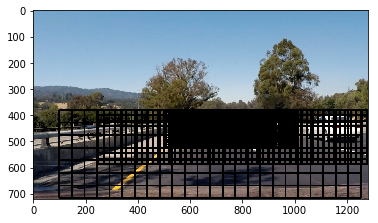

In [10]:
image = mpimg.imread('test_images/test4.jpg')
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[100, None], y_start_stop=[380, None], xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[250, None], y_start_stop=[380, 600], xy_window=(144, 144), xy_overlap=(0.85, 0.85))
windows += slide_window(image, x_start_stop=[500, 1000], y_start_stop=[380, 520], xy_window=(96, 96), xy_overlap=(0.9, 0.9))
print(len(windows))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [ ]:
#train()

In [11]:
with open('model.p', 'rb') as model:
    train_pickle = pickle.load(model)
    
clf = train_pickle['model']
scaler = train_pickle['scaler']

In [ ]:

out_win = search_windows(image, windows, clf, scaler, color_space='YCrCb',
                         spatial_size=(32, 32), hist_bins=32,
                         hist_range=(0, 256), orient=9,
                         pix_per_cell=8, cell_per_block=2,
                         hog_channel='ALL')
window_img = draw_boxes(image, out_win, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [ ]:
# Add heat to each box in box list
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,out_win)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
with open('model.p', 'rb') as model:
    train_pickle = pickle.load(model)
    
clf = train_pickle['model']
scaler = train_pickle['scaler']

test_images = glob.glob('test_images/*.jpg')

for i, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    
    result = run_pipeline(img, Video=False)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

    cv2.imshow('img', result)
    cv2.waitKey(500)
    
cv2.destroyAllWindows()

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_output = 'output.mp4'

clip1 = VideoFileClip("project_video.mp4")

lane_clip = clip1.fl_image(run_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 94%|███████████████████████████████████████████████▋   | 1180/1261 [1:18:57<05:49,  4.32s/it]